<a href="https://colab.research.google.com/github/tatsuhiko-suyama/Something-/blob/main/5_12_%E3%83%A2%E3%83%87%E3%83%AB%E3%83%AA%E3%82%B9%E3%82%AF%E5%AE%9A%E9%87%8F%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import analysis_flow as af
import logging                       # ← これを追加
logging.basicConfig(level=logging.INFO,
                    format="%(levelname)s: %(message)s")

# ---- 0. グローバル定数 & ベースパラメータ -----------------------
K = M = 4
MU_TILDE = 0.03
ALPHA_GRID = np.linspace(0,1,1001)  # 0〜1 を 0.01 刻み
#   （以下は設計書どおり。ご自身のパラメータ設定に合わせて下さい）
r_base  = np.array([0.02, 0.03, 0.04, 0.05])
sigma_base = np.array([0.20, 0.25, 0.30, 0.35])
Delta_A = np.array([[+1, 1, -1, -1],
                    [+1, 1, -1, -1],
                    [+2, -1, +2, -2],
                    [+2, -2, +2, -2]], float)
Delta_r = Delta_A/1000; Delta_sigma = Delta_A/100
def block_corr(r_in: float, r_out: float, *, debug: bool = True) -> np.ndarray:
    """
    Two-sector block correlation matrix with unit diagonal.

    Parameters
    ----------
    r_in : float
        Within-sector off-diagonal correlation.
    r_out : float
        Between-sector correlation.
    debug : bool, default False
        If True, print summary statistics for the generated matrix.

    Returns
    -------
    C : (K,K) ndarray
        Correlation matrix with diag(C)=1.
    """
    k = 4  # use outer-scope K from self-test or call site
    C = np.full((k, k), r_out, dtype=float)
    np.fill_diagonal(C, 1.0)

    mid = k // 2
    for i in range(mid):
        for j in range(mid):
            if i != j:
                C[i, j] = r_in
    for i in range(mid, k):
        for j in range(mid, k):
            if i != j:
                C[i, j] = r_in

    if debug:
        print(f"[block_corr] K={k}, r_in={r_in}, r_out={r_out}")
        print("  Off-diag min:", C[np.triu_indices(k, 1)].min(),
              "max:", C[np.triu_indices(k, 1)].max())
        print("  Diagonal all ones?:", np.allclose(np.diag(C), 1.0))

    return C

C_base = block_corr(0.75,0.50)
tilde_C = [block_corr(0.85,0.40), block_corr(0.65,0.40),
           block_corr(0.65,0.60), block_corr(0.85,0.60)]
V_base  = np.diag(sigma_base) @ C_base @ np.diag(sigma_base)
df = af.run_comparison_analysis_sweep(
    alpha_grid=ALPHA_GRID,
    r_base=r_base, sigma_base=sigma_base, C_base=C_base, V_base=V_base,
    Delta_r_m=Delta_r, Delta_sigma_m=Delta_sigma, tilde_C_list=tilde_C
)


[block_corr] K=4, r_in=0.75, r_out=0.5
  Off-diag min: 0.5 max: 0.75
  Diagonal all ones?: True
[block_corr] K=4, r_in=0.85, r_out=0.4
  Off-diag min: 0.4 max: 0.85
  Diagonal all ones?: True
[block_corr] K=4, r_in=0.65, r_out=0.4
  Off-diag min: 0.4 max: 0.65
  Diagonal all ones?: True
[block_corr] K=4, r_in=0.65, r_out=0.6
  Off-diag min: 0.6 max: 0.65
  Diagonal all ones?: True
[block_corr] K=4, r_in=0.85, r_out=0.6
  Off-diag min: 0.6 max: 0.85
  Diagonal all ones?: True


In [6]:
0.029406685293587895/np.sqrt(0.036861095576995906)

np.float64(0.15316585313487016)

csv_schema:
  meta:
    scenario:          "シナリオ名（AllVary / RVary / SigmaVary / CVary）"
    alpha:             "モデルリスク・パラメータ α (0–1)"
    solver_type:       "ロバスト解法の種別（general / half-pair / common_r）"
    iters:             "外側最適化のイテレーション数"
  kpi:
    guarantee_return_rob: "ロバスト π* の保証リターン  minₘ πᵀ rᵐ"
    worst_return_trad:    "伝統 π_trad のワーストケース期待リターン"
    worst_F_trad:         "伝統 π_trad のワーストケース分散 F(π_trad, w)"
    robust_SR:            "ロバスト・シャープレシオ  (w*·r̄) / √H*"
    H_rob:                "ロバスト π* で達成した分散 (H*)"
    HHI_trad:             "伝統ポートフォリオの HHI（集中度指標）"
    HHI_rob:              "ロバストポートフォリオの HHI"
    N_eff_trad:           "伝統ポートフォリオの有効資産数 1/HHI"
    N_eff_rob:            "ロバストポートフォリオの有効資産数"
    turnover:             "∑|π_rob − π_trad|（転換量）"
    gross_exp_trad:       "伝統ポートフォリオのグロス・エクスポージャー"
    gross_exp_rob:        "ロバストポートフォリオのグロス・エクスポージャー"
  weights:
    pi_rob_k:   "資産 k のロバスト最適ウェイト（k = 0 … K−1）"
    pi_trad_k:  "資産 k の伝統的ウェイト       （k = 0 … K−1）"


In [7]:
df.to_csv('result.csv')

In [8]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

csv_path     = "result.csv"      # 入力 CSV
parquet_path = "result.parquet"  # 出力 Parquet
chunksize    = 50_000                 # 5万行ずつ読み込む（調整可）

# ✓ 1回目にスキーマを作成して Parquet writer をオープン
first_chunk = True
parquet_writer = None

for chunk in pd.read_csv(csv_path, chunksize=chunksize):
    # === 必要なら前処理を挟む例 ===
    # chunk = chunk[chunk["scenario"] == "AllVary"]  # ←行フィルタ例
    # chunk = chunk.filter(regex="^(scenario|alpha|SR_rob_m)")  # ←列フィルタ例

    # pandas → pyarrow Table
    table = pa.Table.from_pandas(chunk, preserve_index=False)

    if first_chunk:
        parquet_writer = pq.ParquetWriter(parquet_path, table.schema,
                                          compression="zstd")
        first_chunk = False

    parquet_writer.write_table(table)

parquet_writer.close()
print("✅ Parquet 出力完了:", parquet_path)


✅ Parquet 出力完了: result.parquet


In [13]:
import pandas as pd
import re
import pyarrow.parquet as pq   # 必要に応じて: pip install pyarrow

# --- 入出力ファイル名 ----------------------------------------------------
parquet_path = "result.parquet"   # 元 Parquet
csv_out      = "allvary_sr.csv"        # 出力 CSV
# ------------------------------------------------------------------------

# 1) Parquet のスキーマから列名を取得
schema = pq.ParquetFile(parquet_path).schema
all_cols = schema.names               # Parquet 内すべての列名リスト

# 2) 正規表現で SR_rob_m<number> 形式を抽出
sr_cols = [c for c in all_cols if re.fullmatch(r"SR_rob_m\d+", c)]
print("抽出した SR 列:", sr_cols[:10], "...", f"({len(sr_cols)} 列)")

# 3) 必要列だけ読み込み
usecols = ["scenario", "alpha"] + sr_cols
df = pd.read_parquet(parquet_path, columns=usecols)

# 4) AllVary 行に限定
df_allvary = df[df["scenario"] == "AllVary"]

# 5) CSV 保存
df_allvary.to_csv(csv_out, index=False)
print(f"✅ 変換完了: {csv_out} へ {len(df_allvary)} 行を書き出しました。")


抽出した SR 列: ['SR_rob_m0', 'SR_rob_m1', 'SR_rob_m2', 'SR_rob_m3'] ... (4 列)
✅ 変換完了: allvary_sr.csv へ 1001 行を書き出しました。


<ipython-input-15-023342f9d771>:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_sr    = float(np.trapz(sr_mean, alpha_vals))
<ipython-input-15-023342f9d771>:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_sr    = float(np.trapz(sr_mean, alpha_vals))
<ipython-input-15-023342f9d771>:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_sr    = float(np.trapz(sr_mean, alpha_vals))
<ipython-input-15-023342f9d771>:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_sr    = float(np.trapz(sr_mean, alpha_vals))


✅ Plot saved to elasticity_by_scenario.png
✅ Summary saved to elasticity_summary.csv
    scenario  alpha_star  elasticity_at_alpha_star  area_SR_curve
0    AllVary       0.197              4.498310e-08       0.158228
1      CVary       0.000              5.560976e-09       0.157727
2      RVary       0.000              2.073998e-06       0.158308
3  SigmaVary       0.628             -8.341079e-07       0.158123


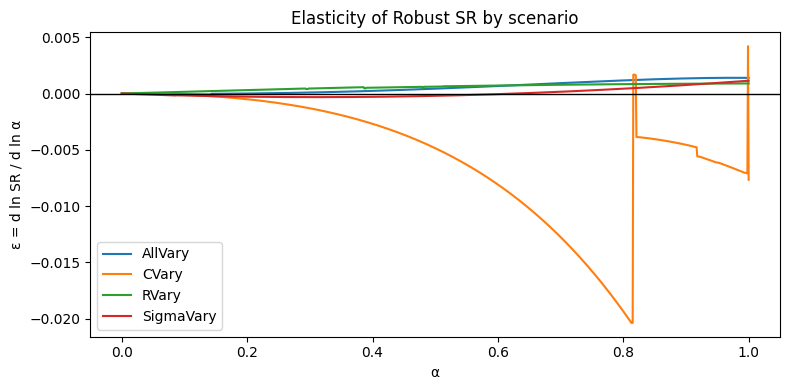

In [15]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pathlib import Path

# ----------- パラメータ --------------------------------------------------
csv_path   = "result.csv"          # 元 CSV
out_plot   = "elasticity_by_scenario.png"
summary_csv = "elasticity_summary.csv"
alpha_offset = 1e-6                # log(α) 安定化用
smooth_win   = 5                   # rolling median window
# ------------------------------------------------------------------------

# 1) ヘッダ行を読み、SR_rob 列を抽出
with open(csv_path, "r") as f:
    header_line = f.readline().strip()
all_cols = header_line.split(",")
sr_cols  = [c for c in all_cols if re.fullmatch(r"SR_rob_m\d+", c)]
if not sr_cols:
    raise RuntimeError("SR_rob_m* 列が見つかりません。")

usecols = ["scenario", "alpha"] + sr_cols
dtype_map = {c: np.float64 for c in sr_cols}
dtype_map.update({"alpha": np.float64, "scenario": str})

# 2) 必要列だけチャンク読み込み
chunks = pd.read_csv(csv_path, usecols=usecols, dtype=dtype_map,
                     chunksize=50_000)

df = pd.concat(chunks, ignore_index=True)
df.set_index(["scenario", "alpha"], inplace=True)

# 3) シナリオ別 Elasticity 計算
results = []
plt.figure(figsize=(8,4))
for sc, sub in df.groupby(level=0):
    sub = sub.sort_index()
    alpha_vals = sub.index.get_level_values("alpha").astype(float).values
    sr_mean = sub[sr_cols].mean(axis=1).values.astype(float)

    log_alpha = np.log(alpha_vals + alpha_offset)
    log_sr    = np.log(sr_mean + 1e-12)
    epsilon   = np.gradient(log_sr, log_alpha)  # elasticity
    eps_sm    = pd.Series(epsilon).rolling(smooth_win, center=True,
                                           min_periods=1).median().values

    # α* (|ε|最小)、SR 曲線面積
    idx_star  = np.argmin(np.abs(eps_sm))
    alpha_star = float(alpha_vals[idx_star])
    eps_star   = float(eps_sm[idx_star])
    area_sr    = float(np.trapz(sr_mean, alpha_vals))

    results.append({
        "scenario": sc,
        "alpha_star": alpha_star,
        "elasticity_at_alpha_star": eps_star,
        "area_SR_curve": area_sr
    })

    # 描画（α が多いと重いので 1000 点以下に subsample）
    step = max(1, len(alpha_vals)//1000)
    plt.plot(alpha_vals[::step], eps_sm[::step], label=sc)

plt.axhline(0, color="black", linewidth=1)
plt.xlabel("α")
plt.ylabel("ε = d ln SR / d ln α")
plt.title("Elasticity of Robust SR by scenario")
plt.legend()
plt.tight_layout()
plt.savefig(out_plot, dpi=300)
print("✅ Plot saved to", out_plot)

# 4) サマリを CSV として保存
summary_df = pd.DataFrame(results)
summary_df.to_csv(summary_csv, index=False)
print("✅ Summary saved to", summary_csv)
print(summary_df)
